In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)

def sample_gumbel(shape, eps=1e-20):
    """Sample from Gumbel(0, 1)"""
    U = np.random.uniform(0, 1, shape)
    return -np.log(-np.log(U + eps) + eps)

def gumbel_max_sample(logits, n_samples):
    """Generate n_samples using Gumbel-Max trick"""
    # Expand logits to match the number of samples
    logits_expanded = np.tile(logits, (n_samples, 1))
    
    # Generate Gumbel noise
    gumbel_noise = sample_gumbel(logits_expanded.shape)
    
    # Add noise to logits and get argmax
    perturbed_logits = logits_expanded + gumbel_noise
    samples = np.argmax(perturbed_logits, axis=1)
    
    return samples

def categorical_sample(probs, n_samples):
    """Generate n_samples using numpy's choice function"""
    return np.random.choice(len(probs), size=n_samples, p=probs)

# Set parameters
logits = np.array([2.0, 0.5, 0.5, 1.0, 0.3])
n_samples = 10000

# Convert logits to probabilities using softmax
probs = softmax(logits)

print("logits", logits)

print("the probabilities are: ", probs)



logits [2.  0.5 0.5 1.  0.3]
the probabilities are:  [0.50079544 0.11174257 0.11174257 0.18423235 0.09148708]


In [18]:
# Set parameters
logits = np.array([2.0, 0.5, 0.5, 1.0, 0.3])
n_samples = 10000
probs = softmax(logits)

# Generate samples using both methods
gumbel_samples = gumbel_max_sample(logits, n_samples)
categorical_samples = categorical_sample(probs, n_samples)




Logits: [2.  0.5 0.5 1.  0.3]

Theoretical probabilities: [0.50079544 0.11174257 0.11174257 0.18423235 0.09148708]

Categorical sampling frequencies: [0.4943 0.1113 0.1175 0.1867 0.0902]
Gumbel-Max sampling frequencies: [0.5064 0.1097 0.1111 0.1853 0.0875]

Max absolute error: 0.012099999999999944


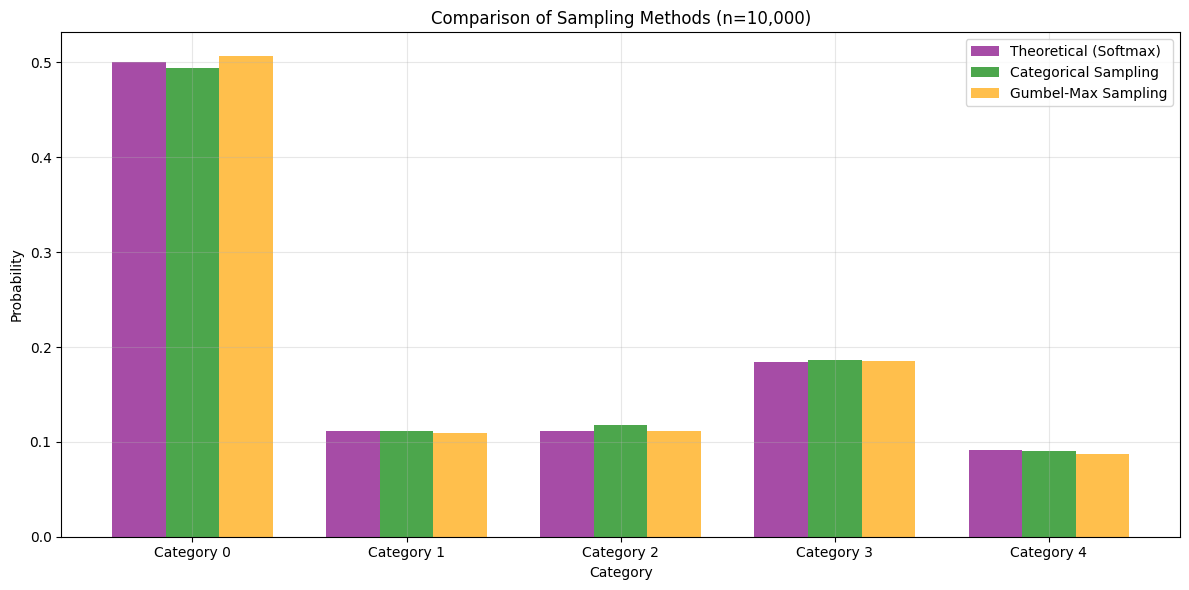

In [19]:
# Compute histograms
gumbel_hist = np.bincount(gumbel_samples, minlength=len(logits)) / n_samples
categorical_hist = np.bincount(categorical_samples, minlength=len(logits)) / n_samples


# Create figure
plt.figure(figsize=(12, 6))

# Set up bar positions
x = np.arange(len(logits))
width = 0.25

# Create bars
plt.bar(x - width, probs, width, label='Theoretical (Softmax)', alpha=0.7, color='purple')
plt.bar(x, categorical_hist, width, label='Categorical Sampling', alpha=0.7, color='green')
plt.bar(x + width, gumbel_hist, width, label='Gumbel-Max Sampling', alpha=0.7, color='orange')

# Customize plot
plt.xlabel('Category')
plt.ylabel('Probability')
plt.title('Comparison of Sampling Methods (n=10,000)')
plt.xticks(x, [f'Category {i}' for i in range(len(logits))])
plt.legend()
plt.grid(True, alpha=0.3)

# Print numerical results
print("Logits:", logits)
print("\nTheoretical probabilities:", probs)
print("\nCategorical sampling frequencies:", categorical_hist)
print("Gumbel-Max sampling frequencies:", gumbel_hist)
print("\nMax absolute error:", np.max(np.abs(categorical_hist - gumbel_hist)))

# Save or display plot
plt.tight_layout()
plt.show()

100%|██████████| 20/20 [00:00<00:00, 55.09it/s] 


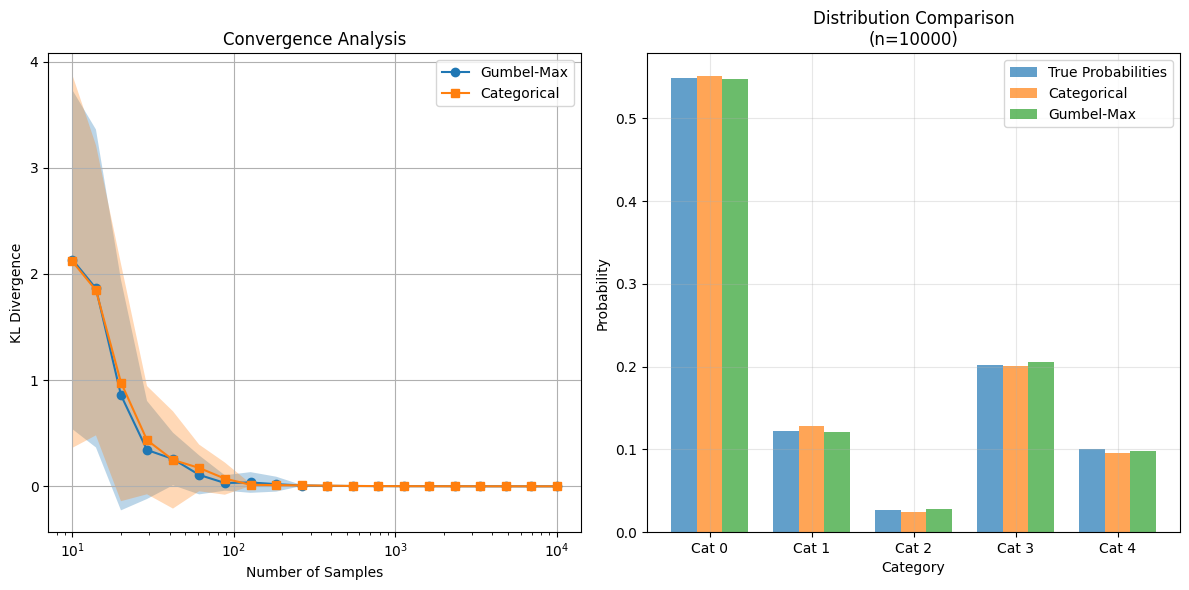


Final KL divergence (n=10000):
Gumbel-Max: 0.000191 ± 0.000130
Categorical: 0.000217 ± 0.000180


In [22]:
def compute_kl_divergence(p, q):
    """Compute KL divergence between two distributions"""
    # Add small epsilon to avoid log(0)
    epsilon = 1e-10
    p = p + epsilon
    q = q + epsilon
    p = p / np.sum(p)
    q = q / np.sum(q)
    return np.sum(p * np.log(p / q))

# Parameters
logits = np.array([2.0, 0.5, -1.0, 1.0, 0.3])
true_probs = softmax(logits)
sample_sizes = np.logspace(1, 4, num=20, dtype=int)
n_trials = 50

# Arrays to store results
kl_div_gumbel = np.zeros((len(sample_sizes), n_trials))
kl_div_categorical = np.zeros((len(sample_sizes), n_trials))

# Run experiments
for i, n_samples in enumerate(tqdm(sample_sizes)):
    for j in range(n_trials):
        # Gumbel-Max sampling
        gumbel_samples = gumbel_max_sample(logits, n_samples)
        gumbel_hist = np.bincount(gumbel_samples, minlength=len(logits)) / n_samples
        kl_div_gumbel[i, j] = compute_kl_divergence(true_probs, gumbel_hist)
        
        # Categorical sampling
        categorical_samples = np.random.choice(len(logits), size=n_samples, p=true_probs)
        categorical_hist = np.bincount(categorical_samples, minlength=len(logits)) / n_samples
        kl_div_categorical[i, j] = compute_kl_divergence(true_probs, categorical_hist)

# Compute mean and std of KL divergence
kl_mean_gumbel = np.mean(kl_div_gumbel, axis=1)
kl_std_gumbel = np.std(kl_div_gumbel, axis=1)
kl_mean_categorical = np.mean(kl_div_categorical, axis=1)
kl_std_categorical = np.std(kl_div_categorical, axis=1)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.semilogx(sample_sizes, kl_mean_gumbel, 'o-', label='Gumbel-Max')
plt.fill_between(sample_sizes, 
                kl_mean_gumbel - kl_std_gumbel,
                kl_mean_gumbel + kl_std_gumbel,
                alpha=0.3)
plt.semilogx(sample_sizes, kl_mean_categorical, 's-', label='Categorical')
plt.fill_between(sample_sizes,
                kl_mean_categorical - kl_std_categorical,
                kl_mean_categorical + kl_std_categorical,
                alpha=0.3)
plt.xlabel('Number of Samples')
plt.ylabel('KL Divergence')
plt.title('Convergence Analysis')
plt.legend()
plt.grid(True)

# Plot final distributions for largest sample size
plt.subplot(1, 2, 2)
width = 0.25
x = np.arange(len(logits))

gumbel_samples = gumbel_max_sample(logits, sample_sizes[-1])
categorical_samples = np.random.choice(len(logits), size=sample_sizes[-1], p=true_probs)

gumbel_hist = np.bincount(gumbel_samples, minlength=len(logits)) / sample_sizes[-1]
categorical_hist = np.bincount(categorical_samples, minlength=len(logits)) / sample_sizes[-1]

plt.bar(x - width, true_probs, width, label='True Probabilities', alpha=0.7)
plt.bar(x, categorical_hist, width, label='Categorical', alpha=0.7)
plt.bar(x + width, gumbel_hist, width, label='Gumbel-Max', alpha=0.7)

plt.xlabel('Category')
plt.ylabel('Probability')
plt.title(f'Distribution Comparison\n(n={sample_sizes[-1]})')
plt.xticks(x, [f'Cat {i}' for i in range(len(logits))])
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final statistics
print(f"\nFinal KL divergence (n={sample_sizes[-1]}):")
print(f"Gumbel-Max: {kl_div_gumbel[-1].mean():.6f} ± {kl_div_gumbel[-1].std():.6f}")
print(f"Categorical: {kl_div_categorical[-1].mean():.6f} ± {kl_div_categorical[-1].std():.6f}")